In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# !gpustat

In [4]:
data_fnames = [f'debug/notebooks/2024-11-20-debug-sona-data/LV_mask_slice{idx}.npy' for idx in range(3)]
test_data = []
for datum_fname in data_fnames:
    test_data.append({
        'myo_masks': np.load(datum_fname, allow_pickle=True)
    })

for datum_idx in range(len(test_data)):
    test_data[datum_idx]['ori_n_frames'] = test_data[datum_idx]['myo_masks'].shape[-1]

In [5]:
# data[0].shape

In [6]:
# test_fname = '/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy'
# test_data = np.load(test_fname, allow_pickle=True).tolist()

In [7]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [8]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


In [9]:
# inference_mask.shape

In [34]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data
from skimage.transform import resize
from skimage.morphology import dilation, disk, closing
import tqdm
# check_data_idx = 0
n_repeats = 5
my_pred_disps = []
for check_data_idx, check_datum in tqdm.tqdm(enumerate(test_data)):
    # if check_data_idx == 0:
    #     continue
    # for skip_diffusion in [True, False]:
    for skip_diffusion in [True]:
    # for skip_diffusion in [False, True]:
        inference_mask_raw = torch.from_numpy(
                resize(test_data[check_data_idx]['myo_masks'][...,0]>0.5, [48,48], anti_aliasing=False)
            )
        if check_data_idx == 0:        
            inference_mask = torch.from_numpy(dilation(inference_mask_raw, disk(2)))
        else:
            inference_mask = inference_mask_raw
        # Prepare Pytorch tensor
        inference_input_video      = torch.from_numpy(test_data[check_data_idx]['myo_masks']).to(device).moveaxis(-1,0)[None, None]
        inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']

        
        if skip_diffusion is True:
            inference_output_dict = network.inference(
                inference_input_video, 
                ori_n_frames=[inference_input_video_ori_frame],
                skip_diffusion=True)[0]
            # Extract prediction
            inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73
            
        else:
            inference_disp_repeats = []
            for repeat_idx in range(n_repeats):
                curr_inference_output_dict = network.inference(
                    inference_input_video, 
                    ori_n_frames=[inference_input_video_ori_frame],
                    skip_diffusion=False)[0]

                # Extract prediction
                curr_inference_disp = curr_inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73
                inference_disp_repeats.append(curr_inference_disp)
            inference_disp = sum(inference_disp_repeats) / n_repeats
            # raise Error('Dontt use this')            
        

        H, W = inference_disp.shape[-2:]
        X, Y = np.meshgrid(np.arange(W), np.arange(H))
        dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
        dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
        mask = inference_mask.numpy()
        Nfr = inference_disp.shape[2]
        strain = pixelstrain(
            X=X, Y=Y, 
            dXt=dXt, dYt=dYt, 
            mask=mask, times=np.arange(Nfr))
        strainCC = strain['CC']
        # for frame_idx in range(strainCC.shape[-1]):
        #     strainCC[...,frame_idx][inference_mask_raw<0.5] = np.nan
            # inference_disp[0,0,frame_idx][inference_mask_raw<0.5] = np.nan
            # inference_disp[0,0,frame_idx][inference_mask_raw<0.5] = np.nan

        my_pred_disps.append(inference_disp)
        if skip_diffusion:
            np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-Disp.npy', inference_disp)
            np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-EccVol.npy', strainCC)
            np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-mask.npy', inference_mask)
        else:
            np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-Disp.npy', inference_disp)
            np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-EccVol.npy', strainCC)
            np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-mask.npy', inference_mask)
        # break
    # break

3it [00:34, 11.35s/it]


In [14]:
inference_disp.shape

torch.Size([1, 2, 31, 48, 48])

In [17]:
check_dict(test_data[0])

myo_masks                                                    (128, 128, 32)      
ori_n_frames                                                 32                  


In [35]:
Sona_mask_resc128 = test_data[1]['myo_masks']
Sona_input_tensor_Strain = torch.tensor(Sona_mask_resc128, dtype=torch.float32)
Sona_input_tensor_Strain = Sona_input_tensor_Strain.unsqueeze(0)
Sona_input_tensor_Strain = Sona_input_tensor_Strain.permute(0, 3, 1, 2)
Sona_input_tensor_Strain = Sona_input_tensor_Strain.to(device)

Sona_inference_input_video_ori_frame = test_data[1]['ori_n_frames']
Sona_inference_output_dict = network.inference(
    Sona_input_tensor_Strain,
    ori_n_frames=[Sona_inference_input_video_ori_frame],
    skip_diffusion=True)[0]

# Extract prediction
Sona_inference_disp = Sona_inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73
Sona_dXt = np.moveaxis(Sona_inference_disp[0, 0].numpy(), 0, -1)
Sona_dYt = np.moveaxis(Sona_inference_disp[0, 1].numpy(), 0, -1)
# np.save(f'dXt_slice{sli}', dXt)
# np.save(f'dYt_slice{sli}', dYt)

In [28]:
my_pred_disps[0].shape

torch.Size([1, 2, 31, 48, 48])

In [29]:
Sona_dXt.shape

(48, 48, 31)

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(Sona_mask_resc128[...,15])
# axs[1].imshow()

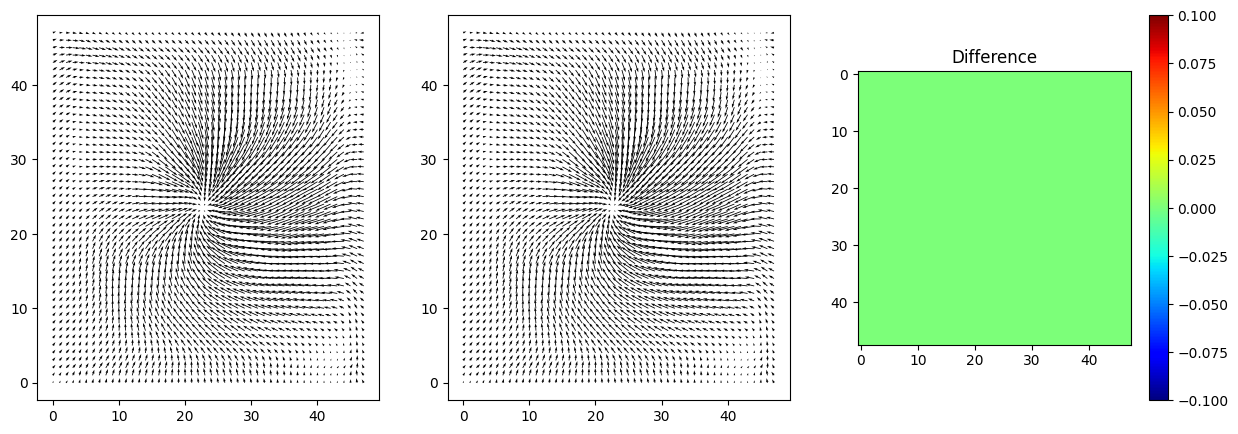

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].quiver(
    Sona_dXt[...,15],
    Sona_dYt[...,15],
    units='xy',
    scale=1,
)
axs[1].quiver(
    my_pred_disps[1][0,0,15],
    my_pred_disps[1][0,1,15],
    units='xy',
    scale=1,
)
axs[2].imshow(Sona_dXt[...,15]-my_pred_disps[1][0,0,15].numpy(), cmap='jet')
axs[2].set_title('Difference')
# add colorbar
cbar = fig.colorbar(axs[2].images[0], ax=axs[2])

In [12]:
# # compare the computed displacement field from two separate runs
# disp_run0 = np.load('debug/notebooks/2024-11-20-debug-sona-data/backup/LaMoD-slice0-SkipDiffusion-Disp.npy')
# disp_run1 = np.load('debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice0-SkipDiffusion-Disp.npy')

In [13]:
plt.quiver()

(1, 2, 31, 48, 48)

In [29]:
inference_disp.shape

torch.Size([1, 2, 31, 48, 48])

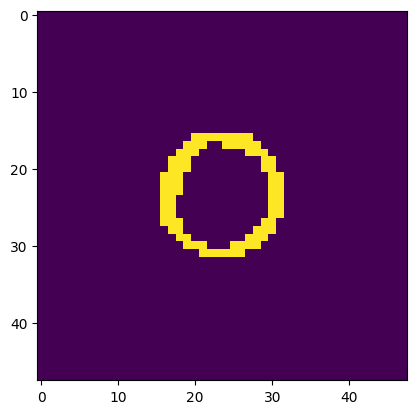

In [16]:
plt.imshow(~np.isnan(check_Ecc[...,0]))

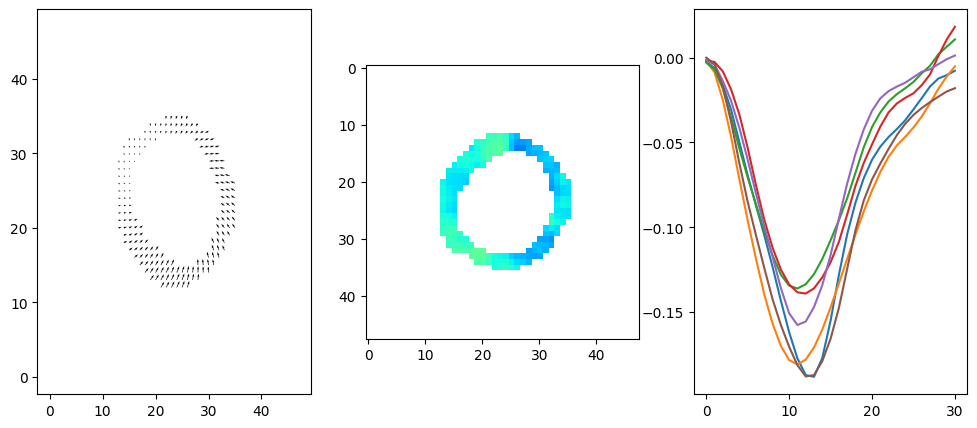

In [21]:
# check the saved files
check_idx = 2
check_approach = 'Avg5Diffusion'
# check_approach = 'SkipDiffusion'
check_disp_fname = f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_idx}-{check_approach}-Disp.npy'
check_Ecc_fname = f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_idx}-{check_approach}-EccVol.npy'
check_disp = np.load(check_disp_fname)
check_Ecc = np.load(check_Ecc_fname)

check_frame_idx = 20
fig, axs = plt.subplots(1, 3, figsize=(12,5))
# Prediction
axs[0].quiver(
    check_disp[0,0,check_frame_idx],
    check_disp[0,1,check_frame_idx],
    units='xy',
    scale=1
)
# axs[0].equal()
axs[1].imshow(check_Ecc[...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)

cine_origin = np.array([24,24])
cine_insertion = np.array([24,0])

cine_strain_imgs = strain['CC']
cine_strain_mask = inference_mask_raw.numpy()
cine_segmental_strain = get_various_segmental_strain_data(
    check_Ecc, 
    ~np.isnan(check_Ecc[...,0]), 
    cine_origin, 
    cine_insertion,
    enable_offset=True,
    offset_degrees=[90, 120, 120],
    generate_layerid_map=False)
# fig, axe = plt.subplots(1, 1, figsize=(8, 5))
for sector_idx in range(6):
    axs[2].plot(cine_segmental_strain['CCs6'][sector_idx])

In [49]:
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data

cine_origin = np.array([24,24])
cine_insertion = np.array([24,0])

cine_strain_imgs = strain['CC']
cine_strain_mask = inference_mask_raw.numpy()
cine_segmental_strain = get_various_segmental_strain_data(
    cine_strain_imgs, 
    cine_strain_mask, 
    cine_origin, 
    cine_insertion,
    enable_offset=True,
    offset_degrees=[90, 120, 120],
    generate_layerid_map=False)

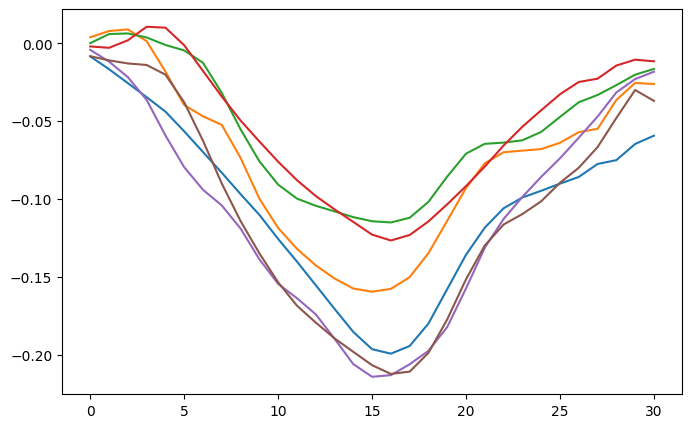

In [51]:
fig, axe = plt.subplots(1, 1, figsize=(8, 5))
for sector_idx in range(6):
    axe.plot(cine_segmental_strain['CCs6'][sector_idx])